# OPC Resampling Script

This script sums rows of the OPC size distributions reaches a threshold peak.

In [103]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import datetime as dt
from datetime import time
import math
from datetime import datetime

## Define Functions

In [104]:
def reader(path, first_var):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the fir column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # rip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns, low_memory=False)
    #Check for duplicated metadata, remove metadata rows based on string "OPC SN"
    if len(d)>0:
        if isinstance(d.iloc[0,0], str):
            dup_meta = [n for n, i in enumerate(d.iloc[:,0]) if 'OPC SN' in i]
            if len(dup_meta) > 0:
                for line in dup_meta:
                    #Deletes duplicate metadata rows from dataframe
                    d.drop(np.arange(line,line+68), inplace = True)
                    # Apply the function to each column
                    d_og = d.copy()
                    for c in d.keys():
                        try:
                            d[c] = pd.to_numeric(d_og[c])
                        except:
                            d[c] = d_og[c]
                    #d = d.apply(pd.to_numeric, ‘raise’,)
                    
    # Creates datetime columns
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'YY/MM/DD' and 'HR:MN:SC' in d.keys():
        d['dt'] = pd.to_datetime(str(20) + d['YY/MM/DD'] + ' ' + d['HR:MN:SC'], format='%Y/%m/%d %H:%M:%S')
    return d

In [105]:
def glob_reader(file_key, first_var, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        f = reader(paths[i], first_var)
        if len(f)>0:
            d.append(f)
    d = pd.concat(d).reset_index()
    return d

In [106]:
def add_bin_sum(d):
    '''
    Adds a column that sums all the bins.

    :param d: input pandas DataFrame
    :return: pandas DataFrame with 'bin_sum' column
    '''
    d = d.copy()
    col_w_bin = [col for col in d.columns if 'bin' in col]
    d['bin_sum'] = d[col_w_bin].sum(numeric_only = True, axis=1)
    return d

In [107]:
def calc_dNdlogDp(data, bins):
    '''
    Calculating dN/dlogDp for OPCs. Requires dlogDp to be calculated for bins.

    :param data: pandas DataFrame
    :param bins: pandas DataFrame of bins
    :return: pandas DataFrame
    '''
    
    dNdlogDp = []
    for binN in bins.index[:-1]:
        dNdlogDp.append(data[f'bin{binN}']/bins.loc[binN, 'dlogDp'])
    dNdlogDp = pd.concat(dNdlogDp, axis = 1)
    dNdlogDp.columns = [f'{i}_norm' for i in dNdlogDp.columns]
    
    return dNdlogDp

In [108]:
def get_sems_periods(flight_date):
    '''
    Gets periods of SEMS sampling
    :param flight_data: Datetime object with the flight day of interest
    :return: pandas DataFrame of SEMS sampling periods
    '''

    #Filtering for RF
    line_breaks_RF = line_breaks.loc[[((line_breaks.loc[i,'Switch_Start_UTC'].date() == flight_date.date()) 
                                       or (line_breaks.loc[i,'Switch_Stop_UTC'].date() == flight_date.date())) 
                                      for i in line_breaks.index]]
    
    #Making sure rows are ordered before we reset index for easier querying
    # line_breaks_RF.sort_values('Switch_Start_UTC', inplace = True)
    line_breaks_RF.reset_index(drop = True, inplace = True)
    
    #Replace NaT with dummy value based on available timestamp
    for i in line_breaks_RF.index:
        if type(line_breaks_RF.loc[i, 'Switch_Stop_UTC']) != pd.Timestamp:
            line_breaks_RF.loc[i, 'Switch_Stop_UTC'] = line_breaks_RF.loc[i, 'Switch_Start_UTC']+dt.timedelta(seconds = 1)
        if type(line_breaks_RF.loc[i, 'Switch_Start_UTC']) != pd.Timestamp:
            line_breaks_RF.loc[i, 'Switch_Start_UTC'] = line_breaks_RF.loc[i, 'Switch_Stop_UTC']-dt.timedelta(seconds = 1)
        
    #Adding rows for first (before first switch) and last (after last switch) timestamps 
    first_dt = dt.datetime.combine(line_breaks_RF.loc[0, 'Switch_Start_UTC'], time.min) 
    last_dt = dt.datetime.combine(line_breaks_RF.loc[len(line_breaks_RF)-1, 'Switch_Stop_UTC'], time.max)
    line_breaks_RF = line_breaks_RF.copy()
    line_breaks_RF.loc[-1, line_breaks_RF.keys()] = [np.nan, np.nan, first_dt, 'OFF', 'SEMS']
    line_breaks_RF.loc[len(line_breaks_RF)-1, line_breaks_RF.keys()] = [np.nan, last_dt, np.nan, 'SEMS', 'OFF']
    line_breaks_RF.index += 1
    line_breaks_RF.sort_index(inplace = True)
    # line_breaks_RF.sort_values(by = ['Switch_Start_UTC', 'Switch_Stop_UTC'], inplace = True)
    
    #Filtering only for SEMS switches
    sems_switches = (line_breaks_RF[['LARGE_From', 'LARGE_To']] == 'SEMS').values.sum(1)
    line_breaks_RF = line_breaks_RF[sems_switches==1] #These are the switches involving the SEMS
    
    output = [(math.floor(i/2), 
               line_breaks_RF.loc[i, f'Switch_{"Stop" if i%2==0 else "Start"}_UTC']) for i in line_breaks_RF.index]
    groups = {}
    for l in output:
        groups.setdefault(l[0], []).append(l[1])
    
    output_sorted = list(groups.values())
    return output_sorted

In [109]:
def get_flight_periods(flight_date):
    '''
    Gets period of flight when LARGE filter is off
    :param flight_data: Datetime object with the flight day of interest
    :return: pandas DataFrame of the flight period
    '''
    out=[]
    row =  flight_times.loc[[((flight_times.loc[i,'LARGE_Filter_Off_UTC'].date() == flight_date.date()) 
                                       or (flight_times.loc[i,'Landing_UTC'].date() == flight_date.date())) 
                                      for i in flight_times.index]]
    return [[pd.to_datetime(row['LARGE_Filter_Off_UTC'].values[0]), pd.to_datetime(row['LARGE_Filter_On_UTC'].values[0])]]

In [110]:
def crop(df, sems_per):
    '''
    Crops data based on the SEMS sampling periods
    :param df: pandas DataFrame
    :param sems_per: pandas DataFrame of flight periods outputted from get_flight_periods()
    :return: pandas DataFrame
    '''
    combined_mask = pd.Series([False] * len(df))
    
    for start_date, end_date in sems_per:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        mask = (df['dt'] >= start_date) & (df['dt'] <= end_date)
        combined_mask = combined_mask | mask  # Combine masks with OR operation
    
    return df.loc[combined_mask]

### Main Function

In [111]:
def process(path, f_name, line_sw=False, min_peak = 2.5):
    '''
    Resamples the raw OPC data by using changes in RH and Dp
    :param path: path to the folder containing the raw data
    :param f_name: str to added to end of file name
    :line_sw: boolean to determine if line switches occurred during the flight
    :min_peak: the minimum peak threshold determining when a new sampled is created
    :return: pandas DataFrame of resampled data
    '''

    # read the data files
    dopc = add_bin_sum(glob_reader('OPC_212', '#YY/MM/DD', subfolder = path)).drop_duplicates(subset='dt', keep='first')
    hopc = add_bin_sum(glob_reader('OPC_210', '#YY/MM/DD', subfolder = path)).drop_duplicates(subset='dt', keep='first')
    dash = glob_reader('DASH_FLOW', '#DOY.Frac', subfolder = path).drop_duplicates(subset='dt', keep='first')
    sems = glob_reader('SEMS_DATA', '#DOY.Frac', subfolder = path).drop_duplicates(subset='dt', keep='first')
    
    # merge the DataFrames based on the DOPC times
    merged = pd.merge_asof(dopc, hopc, on='dt', direction = 'nearest', tolerance=timedelta(seconds=1)).drop(columns=['index_x'])
    merged = pd.merge_asof(merged, dash, on='dt', direction = 'nearest', tolerance=timedelta(seconds=1))
    merged = pd.merge_asof(merged, sems, on='dt', direction = 'nearest', tolerance=timedelta(seconds=1))
    
    # crop the data depending on whether there was a line switch or not
    if line_sw:
        merged = crop(merged, sems_per).reset_index().drop(columns=['index']) # for SEMS sampling
    merged = crop(merged, ft).reset_index().drop(columns=['index']).dropna(how='any', ignore_index=True) # for large inlet off
    
    # create columns which are the difference between rows
    merged_diff = merged[['dt', 'UpSt_Dia', 'HM_RH']].diff()
    merged[['dt.diff', 'UpSt_Dia.diff', 'HM_RH.diff']] = merged_diff

    # get the names of the columns with bin[#]_x and bin[#]_y which corresponds to the DOPC and HOPC, respectively
    col_w_bin = [c for c in merged.columns if 'bin' in c and 'sum' not in c]
    col_w_DO_bin = [c for c in merged.columns if 'bin' in c and 'x' in c and 'sum' not in c]
    col_w_HO_bin = [c for c in merged.columns if 'bin' in c and 'y' in c and 'sum' not in c]

    new_group = True # boolean to mark the beginning of new group of samples

    # lists which represent the start and end of samples
    start_i = []
    end_i = []

    delay = False # boolean to wait for a delay between switching Dp's

    for i in range(0,len(merged)):
        row = merged.iloc[i]

        if delay == False:
            if new_group:
                start_i.append(i) # append the start of the new sample
                new_group = False
                
            if abs(row['UpSt_Dia.diff']) > 0: # if the diameter is changed, make a new sample
                end_i.append(i)
                new_group = True
                dt_switch = row['dt']+timedelta(seconds=16) # adds 16 second delay
                delay = True
                c_i = 0

            elif abs(row['HM_RH.diff']) > 1.5: # if the RH changes by 1.5% in one second, make a new sample
                end_i.append(i)
                new_group = True
        
        else: # wait till the delay time is greater than set delay
            if row['dt'] > dt_switch:
                delay = False

        if i == len(merged)-1: # if at the end of the data, make sure the last index is appended
            if len(start_i) > len(end_i):
                end_i.append(i)
    
    # columns for output DataFrame
    col = ['Samp_Num', 'Start_Date_Time_UTC', 'Mid_Date_Time_UTC', 'Stop_Date_Time_UTC', 'Samp_Time_s', 'data_points', 'UpSt_Dia', 'UpSt_Dia_Sdev', 'HM_RH_Av', 'HM_RH_Sdev', 'HO_RH_Av', 'HO_RH_Sdev', 'HO_below_cnts', 'min_DO_sample_flw', 'min_HO_sample_flw']
    
    # creates column labels for DOPC, HOPC, and both
    comb_bins = []
    dopc_labels = []
    hopc_labels = []
    for i in range(1,73):
        if i < 10:
            dopc_labels.append('DO_Bin0'+str(i))
            hopc_labels.append('HO_Bin0'+str(i))
        else:
            dopc_labels.append('DO_Bin'+str(i))
            hopc_labels.append('HO_Bin'+str(i))
        
        if i < 10:
            col.append('DO_Bin0'+str(i))
            comb_bins.append('DO_Bin0'+str(i))
        else:
            col.append('DO_Bin'+str(i))
            comb_bins.append('DO_Bin'+str(i))
    for i in range(1,73):
        if i < 10:
            col.append('HO_Bin0'+str(i))
            comb_bins.append('HO_Bin0'+str(i))
        else:
            col.append('HO_Bin'+str(i))
            comb_bins.append('HO_Bin'+str(i))

    output = pd.DataFrame(columns = col) # creats output DataFrame with columns
    out_acc = 0 # acc used to add new rows to output
    
    for i in tqdm(range(0,len(start_i))): # cycles through the data samples created in the first loop
        subset = merged.iloc[start_i[i]:end_i[i]+1].reset_index()
        DO_n_sum = 0
        HO_n_sum = 0
        s = 0
        place = False
        for j in range(0,len(subset)):
            if out_acc == 1851:
                pass
            dt_start = subset.loc[s,'dt']
            DO_n_sum = subset.loc[s:j+1, col_w_DO_bin].sum().max()
            HO_n_sum = subset.loc[s:j+1, col_w_HO_bin].sum().max()
            if subset.loc[j, 'dt.diff'] > timedelta(seconds=2):
                s=j+1
                continue
            elif subset.loc[j, 'dt'] - dt_start > timedelta(minutes=5):
                s=j+1
                continue
        
            
            if DO_n_sum > min_peak / float((bins.loc[[(bins['Dp_nm'] - float(subset.loc[j, 'UpSt_Dia'])).abs().idxmin()], 'dlogDp']).iloc[0]):
                #print(len(output)-1, out_acc, len(subset)-1, s)
                output.loc[out_acc, 'Start_Date_Time_UTC'] = subset.loc[s, 'dt'] - timedelta(seconds=1)
                output.loc[out_acc, 'Stop_Date_Time_UTC'] = subset.loc[j, 'dt']
                output.loc[out_acc, 'Mid_Date_Time_UTC'] = output.loc[out_acc, 'Start_Date_Time_UTC']+(output.loc[out_acc, 'Stop_Date_Time_UTC']-output.loc[out_acc, 'Start_Date_Time_UTC'])/2
                #if j==s:
                    #print((output.loc[out_acc, 'Stop_Date_Time_UTC']-output.loc[out_acc, 'Start_Date_Time_UTC'])/2)
                output.loc[out_acc, 'Samp_Time_s'] = (subset.loc[j, 'dt']-subset.loc[s, 'dt']+timedelta(seconds=1)).total_seconds()

                output.loc[out_acc, 'min_DO_sample_flw'] = subset.loc[s:j+1, 'sample_flw_x'].min()
                output.loc[out_acc, 'min_HO_sample_flw'] = subset.loc[s:j+1, 'sample_flw_y'].min()
                
                output.loc[out_acc, 'data_points'] = j-s+1

                output.loc[out_acc, 'UpSt_Dia'] = subset.loc[s:j+1, 'UpSt_Dia'].mean()
                output.loc[out_acc, 'HM_RH_Av'] = subset.loc[s:j+1, 'HM_RH'].mean()
                output.loc[out_acc, 'HO_RH_Av'] = subset.loc[s:j+1, 'HO_RH'].mean()

                output.loc[out_acc, 'UpSt_Dia_Sdev'] = subset.loc[s:j+1, 'UpSt_Dia'].std()
                output.loc[out_acc, 'HM_RH_Sdev'] = subset.loc[s:j+1, 'HM_RH'].std()
                output.loc[out_acc, 'HO_RH_Sdev'] = subset.loc[s:j+1, 'HO_RH'].std()

                output.loc[out_acc, comb_bins] = list(subset.loc[s:j+1, col_w_bin].sum())
                if HO_n_sum*2 > min_peak / float((bins.loc[[(bins['Dp_nm'] - float(subset.loc[j, 'UpSt_Dia'])).abs().idxmin()], 'dlogDp']).iloc[0]):
                    output.loc[out_acc, 'HO_below_cnts'] = 0
                else:
                    output.loc[out_acc, 'HO_below_cnts'] = 1
                s = j+1

                if len(output)>1:
                    if output.loc[out_acc, 'Start_Date_Time_UTC'] < output.loc[out_acc-1, 'Stop_Date_Time_UTC']:
                        print('WARNING: Start time before last stop time')
    
                HO_n_sum = 0
                DO_n_sum = 0
                out_acc += 1

    output = output[output['HM_RH_Sdev']<5]
    output = output[output['UpSt_Dia_Sdev']==0]
    output = output.drop(columns=['UpSt_Dia_Sdev'])

    d_m_b = output[dopc_labels].astype('float').idxmax(axis=1)
    output = output[(d_m_b != 'DO_Bin01') & (d_m_b != 'DO_Bin02')]

    output = output[output['min_DO_sample_flw'] >= 0]
    output.loc[output['min_HO_sample_flw'] < 0, 'HO_below_cnts'] = 1

    h_m_b = output[hopc_labels].astype('float').idxmax(axis=1)

    output.loc[(h_m_b != 'HO_Bin01') & (h_m_b != 'HO_Bin02'), 'HO_below_cnts'] = 0

    output['Samp_Num'] = output.reset_index().index+1
    output = output.reset_index(drop=True)
    output.to_csv('./processed_opc/DASH_SAMP_PARAM_'+f_name+'.csv', index=None)

    if line_sw:
        dopc_c = crop(dopc, ft).reset_index().drop(columns=['index'])
        dopc_c = crop(dopc_c, sems_per).reset_index().drop(columns=['index'])
    else:
        dopc_c = crop(dopc, ft).reset_index().drop(columns=['index'])

    print('Fraction of data used =', str(round(output['data_points'].sum()/len(dopc_c), 2)))
    print('Data with usable GF =', str(len(output[output['HO_below_cnts']==0])/len(output)))

    s_t = sorted(list(output['Start_Date_Time_UTC'])+list(output['Stop_Date_Time_UTC']))
    fig, axes = plt.subplots(2, figsize=(5, 2.5), sharex='all')

    ax=axes[0]

    output['Time_Diff'] = output['Mid_Date_Time_UTC'].diff().dt.total_seconds() / 60

    # Identify the indices where the time difference is greater than 5 minutes
    gap_indices = output.index[output['Time_Diff'] > 5].tolist()

    old_i = 0
    output_GF = output[output['HO_below_cnts']==0]

    c = ['black', 'red']
    for i in gap_indices:
        ax.plot(output.loc[old_i:i-1,'Mid_Date_Time_UTC'], output.loc[old_i:i-1,'Samp_Time_s'], c='black')
        #ax.scatter(output_GF.loc[old_i:i-1,'Mid_Date_Time_UTC'], output_GF.loc[old_i:i-1,'Samp_Time_s'], c='lime', s=1, zorder=1000)
        ax.set_ylabel('Samp\nDuration [s]\n', rotation=0, labelpad=40, loc='bottom')
        old_i = i
        
    ax.plot(output.loc[old_i:, 'Mid_Date_Time_UTC'], output.loc[old_i:, 'Samp_Time_s'], c='black')

    ax=axes[1]
    ax.scatter(dopc['dt'], ['Raw']*len(dopc), s=.1)
    ax.scatter(s_t, ['Retrieved']*len(s_t), s=.1)
    ax.set_ylim(-1,3)
    date_format = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.set_xlabel('Hour [UTC]')
    fig.tight_layout()
    fig.savefig('./figures/process-'+f_name+'.png')
    return output

In [112]:
bins = pd.read_csv('./data/DASH_Bins_2023.csv').set_index('BinNum')
meta_dir = './meta/'
flight_times = pd.read_csv(f'{meta_dir}ARCSIX_takeoff_landing_times.txt',
                           parse_dates = ['Takeoff_UTC', 'Landing_UTC', 'LARGE_Filter_Off_UTC', 'LARGE_Filter_On_UTC']
                           ).set_index('FltNum')
line_breaks = pd.read_csv(f'{meta_dir}ARCSIX_DASH_SEMS_switch_times.txt',
                            parse_dates = ['Switch_Start_UTC', 'Switch_Stop_UTC']
                            )[['FltNum', 'Switch_Start_UTC', 'Switch_Stop_UTC', 
                               'LARGE_From', 'LARGE_To']]

100%|██████████| 114/114 [00:40<00:00,  2.81it/s]


Fraction of data used = 0.81
Data with usable GF = 0.9982745871333497


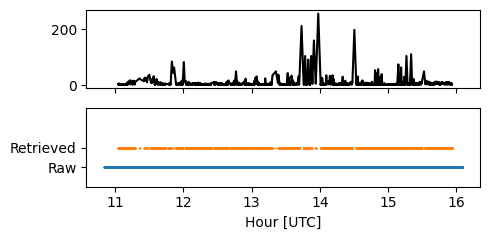

In [113]:
date = '2024_06_10'
#sems_per = get_sems_periods(datetime.strptime(date, '%Y_%m_%d'))
ft = get_flight_periods(datetime.strptime(date, '%Y_%m_%d'))
output = process('./data/DASH-flight-'+date+'/', 'RESAMP_240610', line_sw=False)